In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [3]:
def simulate_samples(N: int = 100, alpha: float=2.3, sigma: float=2., slope: float=4.) -> np.array:
    """
    Description: Generates N samples from a distribution given by the equation : y_n ~ N(alpha + beta *x_n, sigma^2 )
    
    Parameters:
    -----------
        N: int (optional) - The number of samples from the distribution to generate
        alpha: float (optional) - The fixed intercept of the distribution
        sigma: float (optional) - The slope of the distribution.
        slope: float (optional) - The noise parameter for the distribution.
        
    Returns:
    --------
        np.array - An array of the generated samples
    """

    x = np.random.normal(size=N)
    y = alpha + slope * x + sigma * np.random.normal(size=N)
    return x,y

In [4]:
program_code = """

data {
    int<lower=1> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real sigma2;
    real alpha;
    real beta;
}

model {
    sigma2 ~ inv_gamma(1, 1);
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);

    for (n in 1:N) {
        y[n] ~ normal(alpha + beta * x[n], sigma2);
    }
}

"""

In [5]:
def generate_and_sample_model(number_of_samples: int = 10) -> pd.DataFrame:
    """
    Generates samples from the the distribution from simulate_samples and returns
    the best fit to a generated stan model.
    
    Parameters:
    -----------
    number_of_samples : int, optional
        The number of samples from the distribution to generate and use for modeling
        
    Returns:
    --------
    pd.DataFrame
        A table of the best fit model generated from a base stan model and the data.
    """
    
    x_samples, y_samples = simulate_samples(number_of_samples)

    data_dict = {
        'N': number_of_samples,
        'x': x_samples,
        'y': y_samples
    }
    
    model = stan.build(program_code, data=data_dict)
    fit = model.sample(num_chains=4, num_samples=1000, num_warmup=500)

    return fit


In [6]:
results1 = generate_and_sample_model(100)
results2 = generate_and_sample_model(1000)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_wv3jl252/model_hvl6quy2.stan', line 21, column 43: A
    normal distribution is given parameter sigma2 as a scale parameter
    (argument 2), but sigma2 was not constrained to be strictly positive.
Warning in '/tmp/httpstan_wv3jl252/model_hvl6quy2.stan', line 16, column 4: Parameter
    sigma2 is given a inv_gamma distribution, which has strictly positive
    support, but sigma2 was not constrained to be strictly positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000142 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.42 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lp

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_wv3jl252/model_hvl6quy2.stan', line 21, column 43: A
    normal distribution is given parameter sigma2 as a scale parameter
    (argument 2), but sigma2 was not constrained to be strictly positive.
Warning in '/tmp/httpstan_wv3jl252/model_hvl6quy2.stan', line 16, column 4: Parameter
    sigma2 is given a inv_gamma distribution, which has strictly positive
    support, but sigma2 was not constrained to be strictly positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000659 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.59 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lp

Convergence Statistics for model with 100 samples


array([[<Axes: title={'center': 'sigma2'}>,
        <Axes: title={'center': 'sigma2'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

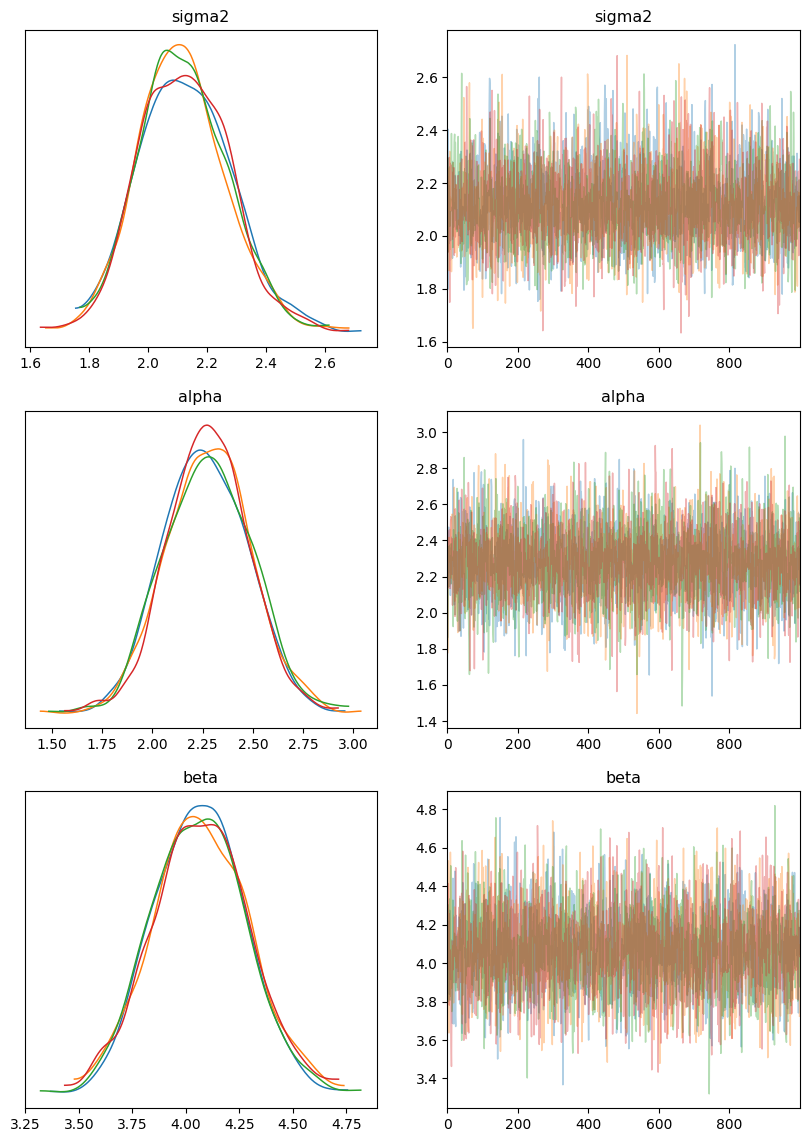

In [7]:
# Efficiency Diagnostics fof posteriors
print('Convergence Statistics for model with 100 samples')
az.plot_trace(results1, compact=False, figsize=(10, 14))

Convergence Statistics for model with 1000 samples


array([[<Axes: title={'center': 'sigma2'}>,
        <Axes: title={'center': 'sigma2'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

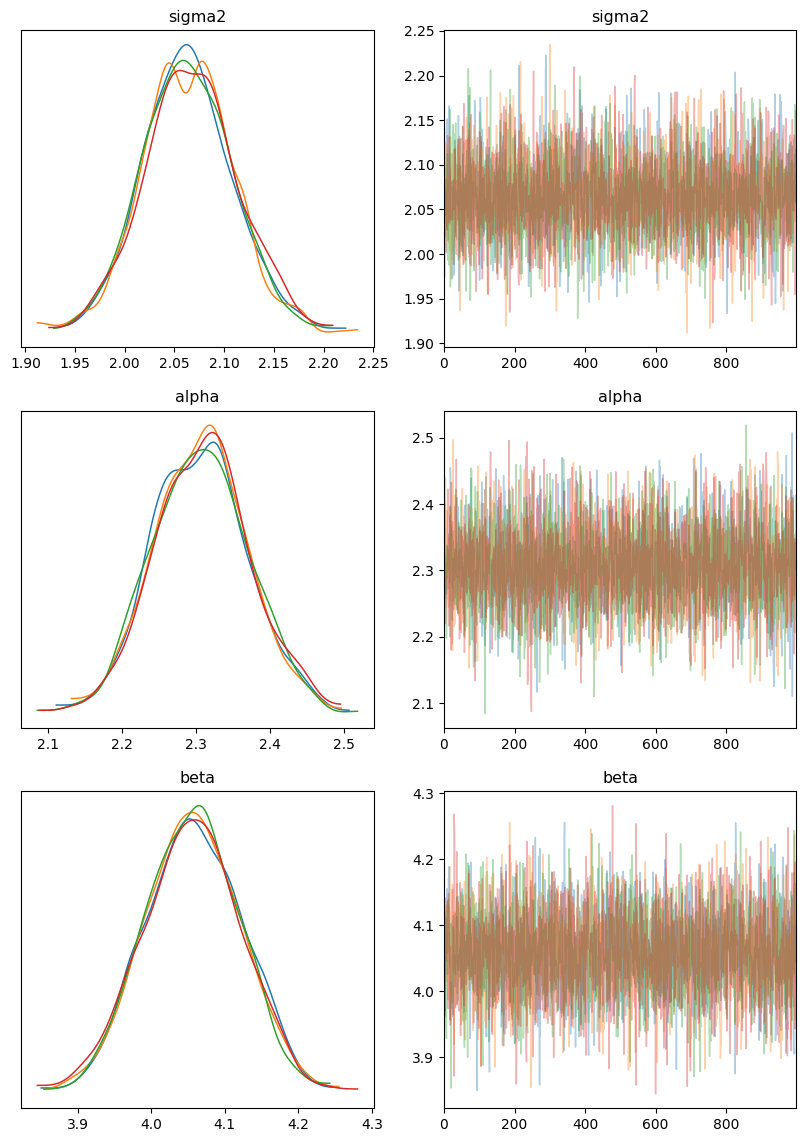

In [8]:
# Efficiency Diagnostics fof posteriors
print('Convergence Statistics for model with 1000 samples')
az.plot_trace(results2, compact=False, figsize=(10,14))

Text(0, 0.5, 'Frequency')

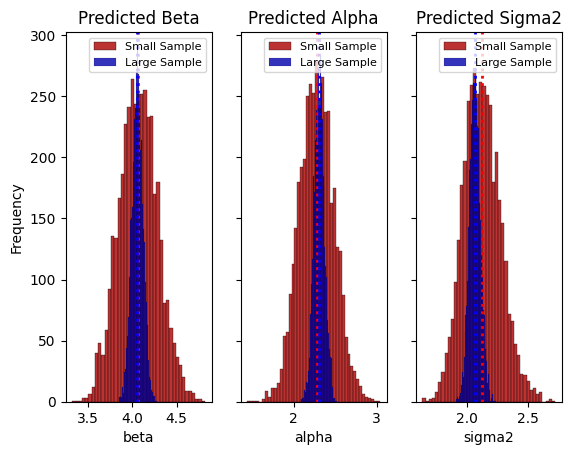

In [21]:
results1_frame = results1.to_frame()
results2_frame = results2.to_frame()

f, ax = plt.subplots(1, 3, sharey=True)

sns.histplot(
        results1_frame, x='beta', ax=ax[0], color='#AA0000', alpha=0.8, lw=2, label=f'Small Sample')
sns.histplot(
        results2_frame, x='beta', ax=ax[0], color='#0000AA', alpha=0.8, lw=2, label=f'Large Sample')

ax[0].axvline(np.mean(results1_frame['beta']), color='red', linestyle='dotted', lw=2)
ax[0].axvline(np.mean(results2_frame['beta']), color='blue', linestyle='dotted', lw=2)

sns.histplot(
        results1_frame, x='alpha', ax=ax[1], color='#AA0000', alpha=0.8, lw=2, label=f'Small Sample')
sns.histplot(
        results2_frame, x='alpha', ax=ax[1], color='#0000AA', alpha=0.8, lw=2, label=f'Large Sample')

ax[1].axvline(np.mean(results1_frame['alpha']), color='red', linestyle='dotted', lw=2)
ax[1].axvline(np.mean(results2_frame['alpha']), color='blue', linestyle='dotted', lw=2)

sns.histplot(
        results1_frame, x='sigma2', ax=ax[2], color='#AA0000', alpha=0.8, lw=2, label=f'Small Sample')
sns.histplot(
        results2_frame, x='sigma2', ax=ax[2], color='#0000AA', alpha=0.8, lw=2, label=f'Large Sample')

ax[2].axvline(np.mean(results1_frame['sigma2']), color='red', linestyle='dotted', lw=2)
ax[2].axvline(np.mean(results2_frame['sigma2']), color='blue', linestyle='dotted', lw=2)

# Labels and embelishments
ax[0].set_title('Predicted Beta')
ax[0].legend(fontsize=8)
ax[0].set_ylabel('Frequency')

ax[1].set_title('Predicted Alpha')
ax[1].legend(fontsize=8)
ax[1].set_ylabel('Frequency')

ax[2].set_title('Predicted Sigma2')
ax[2].legend(fontsize=8)
ax[2].set_ylabel('Frequency')

In [ ]:
# The summary of the results
print('N = 100 summary')
az.summary(results1)

N = 100 summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma2,2.122,0.152,1.843,2.410,0.002,0.002,4212.0,2945.0,1.0
alpha,2.275,0.208,1.864,2.631,0.003,0.003,4664.0,3405.0,1.0
beta,4.067,0.217,3.670,4.497,0.003,0.003,4061.0,2771.0,1.0


In [ ]:
print('N = 1000 summary')
az.summary(results2)

N = 1000 summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma2,2.064,0.046,1.975,2.149,0.001,0.001,4031.0,3096.0,1.0
alpha,2.306,0.064,2.187,2.425,0.001,0.001,4152.0,2924.0,1.0
beta,4.057,0.066,3.939,4.181,0.001,0.001,4037.0,2836.0,1.0
